In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

In [4]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


In [7]:
from bktest.backtest_grid_search import *
tday = datetime.date.today()
roll_name = 'CAL_30b'
df, error_list = load_hist_data(
    start_date=datetime.date(2011,1,1),
    end_date=tday,
    roll_name=roll_name,
    sim_markets=all_markets,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
    

continuous contract stopped at eg1905 for start = 2019-04-02, expiry= 2019-04-03
continuous contract stopped at eb2003 for start = 2020-02-01, expiry= 2020-02-27
continuous contract stopped at lu2012 for start = 2020-10-01, expiry= 2020-10-26
continuous contract stopped at pg2010 for start = 2020-09-05, expiry= 2020-09-07
[('CY', 1), ('ag', 1), ('IF', 1), ('IH', 1), ('IC', 1), ('TS', 0), ('TS', 1)]
product         AP                                                        \
code            c1                                                         
field        close contract      expiry    high     low      mth    open   
date                                                                       
2023-05-19  8552.0    AP310  2023-10-20  8585.0  8480.0  24286.0  8562.0   
2023-05-22  8657.0    AP310  2023-10-20  8660.0  8311.0  24286.0  8521.0   
2023-05-23  8480.0    AP310  2023-10-20  8635.0  8433.0  24286.0  8630.0   
2023-05-24  8442.0    AP310  2023-10-20  8514.0  8374.0  24286.0  

In [ ]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


In [8]:
#ind_metal_mkts
# scenarios = [('tscarry', 'ryield', 0.33, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tscarry', 'basmom', 0.11, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'ryieldsma', 0.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmom', 0.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('xscarry', 'basmomsma', 0.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'momxma', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'mixmom', 0.03, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'rsixea', 0.03, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
#              ('tsmom', 'macdnma', 0.03, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
#              ('tsmom', 'macdnma', 0.03, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
#              ('tsmom', 'macdnma', 0.03, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
#              #('xsmom', 'mom', 0.0, 130, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'mom', 0.0, 230, 1, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 60, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 10, 80, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'rsiema', 0.0, 40, 20, 5, (None, {}, ''), [0.0]), \
#              #('xsmom', 'macdnma', 0.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#              #('xsmom', 'macdnma', 0.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
#             ] 

scenarios_test = [
    ('tscarry', 'ryieldnmb', 0.6, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 1.5, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 2.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 2.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 3.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 3.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.22, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.20, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.18, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),    
    ('custom', 'hc_rb_diff', 0.23, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]

#commod_mkts
scenarios_elite = [ \
        ('tscarry', 'ryieldnmb', 2.0, 1, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 100, 120, 1, (None, {}, ''), [0.0, 0.0]),
        ('tscarry', 'basmomnma', 1.0, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),
#        #('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), 
#        #('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'ryieldnma',1.9, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), 
        ('xscarry-rank_cutoff', 'ryieldnma', 2.1, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2),             
#        #'xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #'xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xscarry-rank_cutoff', 'basmomnma', 2.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        #('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]),
#        ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]),
        ('tsmom', 'hlbrk', 1.1, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('tsmom', 'hlbrk', 0.9, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),             
        ('tsmom', 'macdnma', 0.22, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
        ('tsmom', 'macdnma', 0.20, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#        ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#        #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
        ('xsmom-rank_cutoff', 'hlbrk', 0.75, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2),
#        ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom-rank_cutoff', 'momnma', 0.75, 130, 90, 5, (None, {}, ''), [0.0], 0.2),
        ('xsmom', 'momnma', 0.75, 240, 90, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2),
        #('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2),
        
        ('custom', 'hc_rb_diff', 0.23, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
                   
#         ('custom', 'hc_rb_diff', 0.0767, 30, 122, 1, (None, {}, ''), [0.0, 0.0]),
#         ('custom', 'hc_rb_diff', 0.0767, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),
]


#commod_mkts
scenarios_all = [ \
             ('tscarry', 'ryieldnmb', 2.8, 1, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.7, 100, 120, 1, (None, {}, ''), [0.0, 0.0]), \
             ('tscarry', 'basmomnma', 0.5, 170, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             #('tscarry', 'basmomnma', 0.2, 230, 120, 1, (None, {}, ''), [0.0, 0.0]),\
             ('xscarry', 'ryieldsma', 0.6, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldsma', 0.15, 1, 110, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldsma', 1.5, 1, 190, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma',1.5, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldnma', 1.8, 1, 110, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xscarry', 'ryieldnma', 0.2, 1, 210, 1, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 100, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomsma', 0.6, 220, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 80, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 150, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomnma', 1.5, 220, 120, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'momnma', 0.2, 10, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'momnma', 0.07, 220, 60, 1, (None, {}, ''), [0.0]), \
             ('tsmom', 'hlbrk', 2.0, 10, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.5, 30, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('tsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('tsmom', 'momxma', 0.2, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'momxma', 0.15, 40, 80, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.375, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 30, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'mixmom', 0.3, 220, 1, 10, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 40, 5, (misc.sign, {}, 'sign'), [0.0]), \
             #('tsmom', 'rsixea', 0.25, 30, 110, 5, (misc.sign, {}, 'sign'), [0.0]), \
             ('tsmom', 'macdnma', 0.4, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
             ('tsmom', 'macdnma', 0.3, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
             ('tsmom', 'macdnma', 0.3, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
             #('xsmom', 'mom', 0.15, 160, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 120, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'hlbrk', 1.2, 240, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 20, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'mom', 1.0, 210, 1, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 130, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momnma', 1.0, 240, 90, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 140, 120, 5, (None, {}, ''), [0.0], 0.2), \
             ('xsmom', 'momsma', 0.8, 240, 120, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 70, 60, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 100, 80, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'rsiema', 0.1, 90, 10, 5, (None, {}, ''), [0.0], 0.2), \
             #('xsmom', 'macdnma', 0.1, 8, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 12.5], 0.2), \
             #('xsmom', 'macdnma', 0.1, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
             #('xsmom', 'macdnma', 0.1, 32, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 3.125], 0.2), \
             #('xsmom', 'macdnma', 0.1, 64, 100, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 1.56], 0.2), \
            ]

scenarios_mixed = [('tscarry', 'ryield', 3.0, 1, 1, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 60, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 100, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tscarry', 'basmom', 1.0, 240, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'ryieldsma', 1.0, 1, 50, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 110, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmom', 1.0, 140, 1, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 90, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 #('xscarry', 'basmomsma', 1.0, 230, 20, 5, (None, {}, ''), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 20, 50, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 30, 120, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'momxma', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 10, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'mixmom', 1.0, 20, 1, 10, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 20, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 40, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'rsixea', 1.0, 60, 30, 5, (misc.sign, {}, 'sign'), [0.0, 0.0]), \
                 ('tsmom', 'macdnma', 1.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]), \
                 ('tsmom', 'macdnma', 1.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]), \
                 ('tsmom', 'macdnma', 1.0, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]), \
                 #('xsmom', 'mom', 1.0, 130, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'mom', 1.0, 230, 1, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 60, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 10, 80, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'rsiema', 1.0, 40, 20, 5, (None, {}, ''), [0.0]), \
                 #('xsmom', 'macdnma', 1.0, 16, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 6.25], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 40, 200, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), \
                 #('xsmom', 'macdnma', 1.0, 56, 280, 5, (dh.response_curve, {"response": "absorbing", "param": 2}, "absorbing"), [1.5, 2.5], 0.2), 
] 


scenarios_intraday = [ \
             #('xsfact', 'trdstrsma', 1.0, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             #('xsfact', 'trdstrsma', 1.0, 1, 15, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'trdstrsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'upstdsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrkurtsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 5, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 10, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 15, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
#              ('xsfact', 'lrskewsma', 1.0, 1, 20, 5, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 10, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 20, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
             ('xsfact', 'volmfratiosma', 0.8, 1, 30, 10, (None, {}, ''), [0.0, 0.0], 0.2), \
            ]

# scenarios_test = [
#     ('tsmom', 'macd', 1.0, 8, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 16, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 32, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macd', 1.0, 64, 1, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 8, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 16, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 24, 8, 1, (None, {}, ''), [4.0, 3.0]),
#     ('tsmom', 'macddff', 1.0, 64, 8, 1, (None, {}, ''), [4.0, 3.0]),
# ]




In [9]:
# bad
#     ('tsmom', 'basmomelv', 1.0, 230, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 110, 40, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tsmom', 'basmomelv', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('xsmom-rank', 'momqtl', 1.0, 60, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 120, 122, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momqtl', 1.0, 240, 122, 1, (None, {}, ''), [0.0], 0.2),

# good
#     ('tsmom', 'macd', 1.0, 4, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 8, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 16, 1, 10, (None, {}, ''), [4, 35], 0.2),
#     ('tsmom', 'macd', 1.0, 32, 1, 10, (None, {}, ''), [4, 35], 0.2),
    
# ?? 
# vs ryieldqtl
#     ('tscarry', 'ryieldelv', 1.0, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 61, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldelv', 1.0, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),
# vs other basmomqtl
#     ('tscarry', 'basmomqtl', 1.0, 20, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 70, 244, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.0, 120, 244, 1, (None, {}, ''), [0.0, 0.0]),

# rank or demedian
#     ('tscarry', 'ryieldnmb', 1.0, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'ryieldqtl', 0.8, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

#     ('tscarry', 'basmomnma', 0.5, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.42, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomnma', 0.35, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 2.0, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
#     ('tscarry', 'basmomqtl', 1.8, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'ryieldnma', 1.4, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

#     ('xscarry-rank', 'basmomnma', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xscarry-rank', 'basmomnma', 2.0, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

#     ('tsmom', 'hlbrk', 0.5, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('tsmom', 'hlbrk', 0.5, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
#     ('tsmom', 'macdnma', 0.22, 8, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
#     ('tsmom', 'macdnma', 0.20, 16, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
#     ('tsmom', 'macdnma', 0.18, 24, 160, 5, (dh.response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
#     ('xsmom-rank', 'hlbrk', 0.375, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'hlbrk', 0.375, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
#     ('xsmom-rank', 'momnma', 0.6, 240, 60, 1, (None, {}, ''), [0.0], 0.2),


In [9]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

run name: tscarry-ryieldnmb-1-120-1:

asset = rb, turnover per day = 0.09818434730349161, pnl per trade = 0.029639149608210416
asset = hc, turnover per day = 0.07885597686912879, pnl per trade = 0.04482758925870449
asset = i, turnover per day = 0.07424565036988344, pnl per trade = 0.0055455609982382175
asset = j, turnover per day = 0.12610396266204252, pnl per trade = 0.031124520309563974
asset = jm, turnover per day = 0.11071898415029727, pnl per trade = 0.009819140191237677
asset = ru, turnover per day = 0.088951699795988, pnl per trade = 0.344092420586054
asset = FG, turnover per day = 0.13748460746565816, pnl per trade = 0.007587474954066727
asset = cu, turnover per day = 0.34231783324223725, pnl per trade = 5.043067373581508
asset = al, turnover per day = 0.30983454374147745, pnl per trade = 0.4905494399723322
asset = zn, turnover per day = 0.29270779434549854, pnl per trade = 0.6971017617899801
asset = sn, turnover per day = 0.3020889613235705, pnl per trade = 255.10423884766917


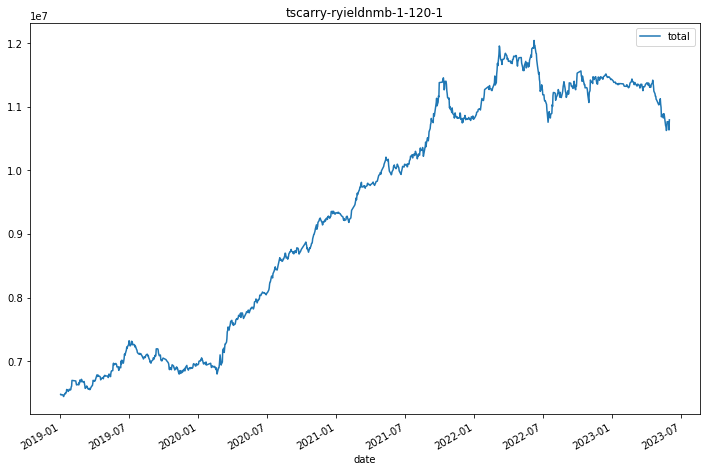

       sharpe       std  sortino
tenor                           
all      1.70  32913.43     2.47
6m      -2.18  39791.54    -2.87
1y      -1.18  55332.91    -1.84
2y       0.46  54796.94     0.73
3y       1.27  48264.22     1.94
4y       1.37  45587.09     2.12
5y       1.45  43446.71     2.22
6y       1.43  40652.27     2.16
7y       1.59  39002.17     2.39
8y       1.53  37985.62     2.30
9y       1.52  36670.67     2.28
10y      1.66  35542.98     2.48
11y      1.77  34484.36     2.62
run name: tscarry-basmomnma-100-120-1:

asset = rb, turnover per day = 0.14831029862205566, pnl per trade = 0.016629217022740138
asset = hc, turnover per day = 0.14985731852333864, pnl per trade = 0.03155593310393745
asset = i, turnover per day = 0.12754742956803364, pnl per trade = 0.0017469795320403157
asset = j, turnover per day = 0.13977752141621447, pnl per trade = 0.022642140226282876
asset = jm, turnover per day = 0.1370375787921711, pnl per trade = 0.0004096273072454398
asset = ru, turnover p

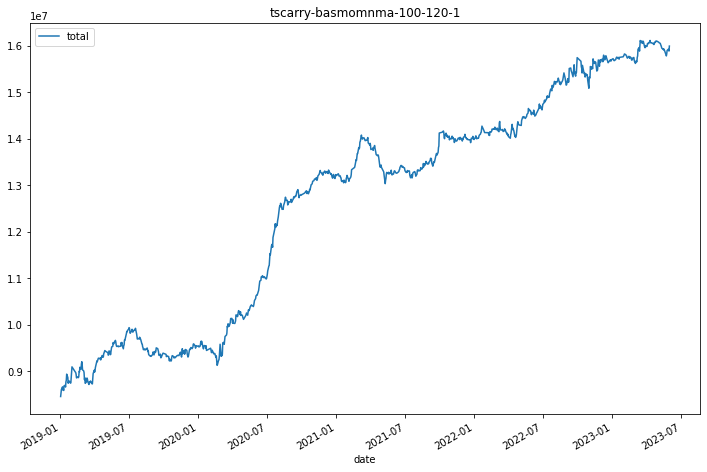

       sharpe       std  sortino
tenor                           
all      1.77  46836.04     2.64
6m       0.94  40547.86     1.65
1y       1.46  63060.74     2.48
2y       1.55  57072.58     2.67
3y       2.08  56208.69     3.51
4y       1.87  55504.91     3.05
5y       1.82  56019.66     2.91
6y       1.69  52857.81     2.67
7y       1.88  51546.88     2.99
8y       1.65  53431.19     2.60
9y       1.59  52109.49     2.50
10y      1.73  50847.55     2.71
11y      1.86  49143.74     2.88
run name: tscarry-basmomnma-170-120-1:

asset = rb, turnover per day = 0.11951545068388741, pnl per trade = 0.024639251932794766
asset = hc, turnover per day = 0.10118676923475191, pnl per trade = 0.027592730937763363
asset = i, turnover per day = 0.09540003635320829, pnl per trade = 0.0017538814657907056
asset = j, turnover per day = 0.12027120239384728, pnl per trade = 0.03347832031445277
asset = jm, turnover per day = 0.09418534614935868, pnl per trade = 0.0015752356686463424
asset = ru, turnover 

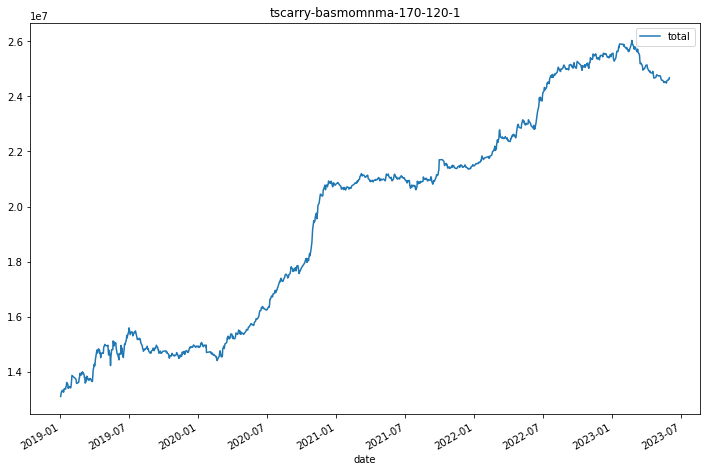

       sharpe       std  sortino
tenor                           
all      1.92  66608.52     2.94
6m      -1.65  62555.42    -2.37
1y       1.51  73570.57     2.63
2y       1.68  70821.06     3.07
3y       2.66  71545.30     4.85
4y       2.21  72908.91     3.80
5y       2.10  77097.62     3.44
6y       1.90  72819.81     3.07
7y       2.14  71884.48     3.51
8y       1.94  77493.09     3.17
9y       1.92  74977.53     3.15
10y      2.08  73100.61     3.39
11y      2.07  70503.91     3.34
run name: xscarry-rank_cutoff-ryieldnma-1-20-1:

asset = rb, turnover per day = 0.18875075804253785, pnl per trade = 0.0717256665621237
asset = hc, turnover per day = 0.13931042059361404, pnl per trade = 0.08551237931762226
asset = i, turnover per day = 0.1389915749354292, pnl per trade = 0.007280039048485238
asset = j, turnover per day = 0.26545497553311725, pnl per trade = -0.006382468836000693
asset = jm, turnover per day = 0.2073563265720875, pnl per trade = 0.0003285127099678782
asset = ru, turn

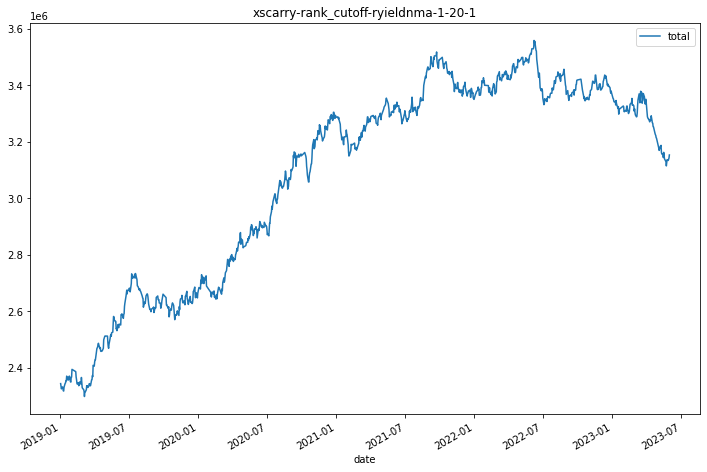

       sharpe       std  sortino
tenor                           
all      1.37  11980.04     2.15
6m      -2.45  13266.28    -3.38
1y      -1.70  13359.24    -2.23
2y      -0.38  13328.60    -0.54
3y       0.41  13583.12     0.62
4y       0.73  13712.13     1.13
5y       0.98  13418.92     1.55
6y       1.05  13295.20     1.64
7y       1.06  13201.55     1.67
8y       1.15  13039.39     1.81
9y       1.11  12922.82     1.76
10y      1.24  12807.49     1.99
11y      1.44  12517.84     2.29
run name: xscarry-rank_cutoff-ryieldnma-1-110-1:

asset = rb, turnover per day = 0.40447089306948497, pnl per trade = 0.0074188513555060055
asset = hc, turnover per day = 0.16294684235038895, pnl per trade = 0.07669678593972405
asset = i, turnover per day = 0.10995990975758672, pnl per trade = 0.009028920196560895
asset = j, turnover per day = 0.24757009908653144, pnl per trade = -0.03559938077742209
asset = jm, turnover per day = 0.2629679470333021, pnl per trade = 0.019876443169371663
asset = ru, t

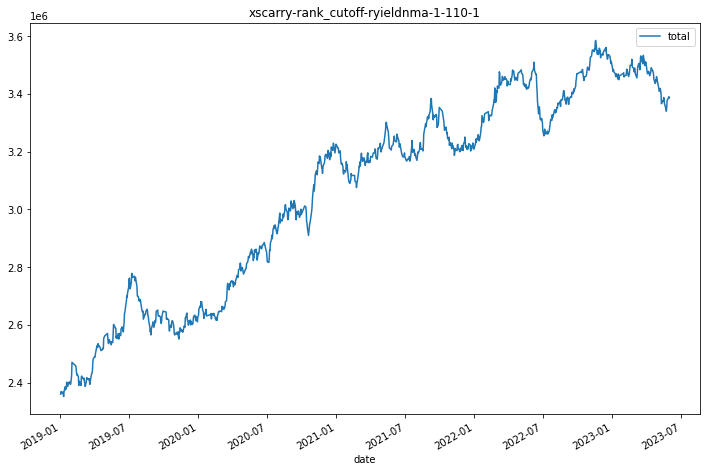

       sharpe       std  sortino
tenor                           
all      1.51  12071.21     2.30
6m      -1.64  12771.73    -2.36
1y      -0.29  13363.50    -0.38
2y       0.38  13881.34     0.55
3y       0.79  14303.61     1.20
4y       0.96  13979.89     1.49
5y       1.26  13729.88     1.98
6y       1.23  13483.39     1.90
7y       1.33  13252.40     2.08
8y       1.31  13081.02     2.04
9y       1.25  12841.47     1.97
10y      1.40  12794.95     2.18
11y      1.52  12469.85     2.34
run name: xscarry-rank_cutoff-basmomnma-80-120-5:

asset = rb, turnover per day = 0.13711558629284243, pnl per trade = 0.26367034186570054
asset = hc, turnover per day = 0.145097010037315, pnl per trade = 0.1744859041393238
asset = i, turnover per day = 0.1326258747557334, pnl per trade = 0.001097372746505019
asset = j, turnover per day = 0.14511159777168803, pnl per trade = 0.12638839831158402
asset = jm, turnover per day = 0.13026639686903063, pnl per trade = 0.009733062871253072
asset = ru, turnov

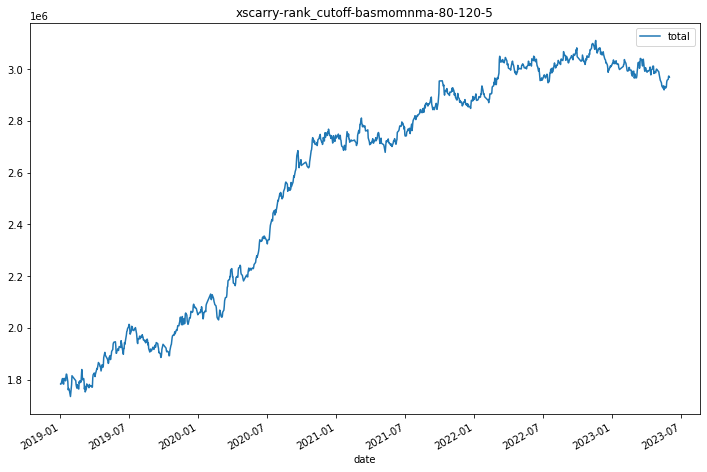

       sharpe       std  sortino
tenor                           
all      1.53  10770.60     2.38
6m      -1.29  11260.75    -1.86
1y      -0.26  11606.69    -0.38
2y       0.70  11739.15     1.10
3y       1.28  12022.44     2.07
4y       1.42  12023.17     2.27
5y       1.40  12437.04     2.20
6y       1.26  12116.45     1.99
7y       1.31  11868.60     2.08
8y       1.27  11690.75     1.98
9y       1.31  11462.83     2.06
10y      1.43  11279.10     2.26
11y      1.56  10966.34     2.44
run name: xscarry-rank_cutoff-basmomnma-150-120-5:

asset = rb, turnover per day = 0.14607384178788355, pnl per trade = 0.13319027102340988
asset = hc, turnover per day = 0.14328492149105887, pnl per trade = 0.17288673995275355
asset = i, turnover per day = 0.09587176927653648, pnl per trade = 0.004090680432773999
asset = j, turnover per day = 0.15879012336351989, pnl per trade = 0.23994409576990147
asset = jm, turnover per day = 0.08363044015664954, pnl per trade = 0.007827782595833782
asset = ru, t

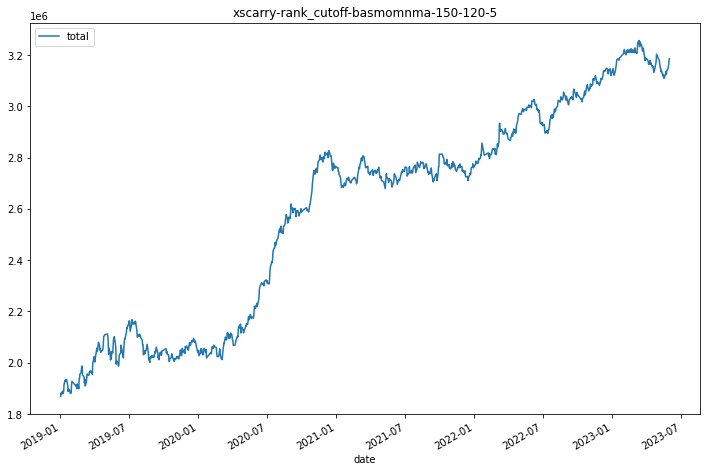

       sharpe       std  sortino
tenor                           
all      1.69  10757.93     2.66
6m       1.06  11019.10     1.66
1y       1.06  10986.81     1.80
2y       1.36  11485.47     2.34
3y       1.74  11879.00     2.91
4y       1.56  12169.19     2.58
5y       1.54  12797.47     2.45
6y       1.41  12251.44     2.23
7y       1.49  12118.00     2.39
8y       1.48  11854.36     2.38
9y       1.50  11419.71     2.40
10y      1.65  11155.42     2.63
11y      1.72  10853.27     2.73
run name: tsmom-hlbrk-10-1-10:

asset = rb, turnover per day = 0.19511815633296567, pnl per trade = 0.05638206909762612
asset = hc, turnover per day = 0.18154332366604856, pnl per trade = 0.20885788430215438
asset = i, turnover per day = 0.18218995859203363, pnl per trade = 0.018206058447058655
asset = j, turnover per day = 0.1798868007304198, pnl per trade = 0.05671830024700122
asset = jm, turnover per day = 0.21829982414118926, pnl per trade = 0.004900814408802623
asset = ru, turnover per day = 0.2

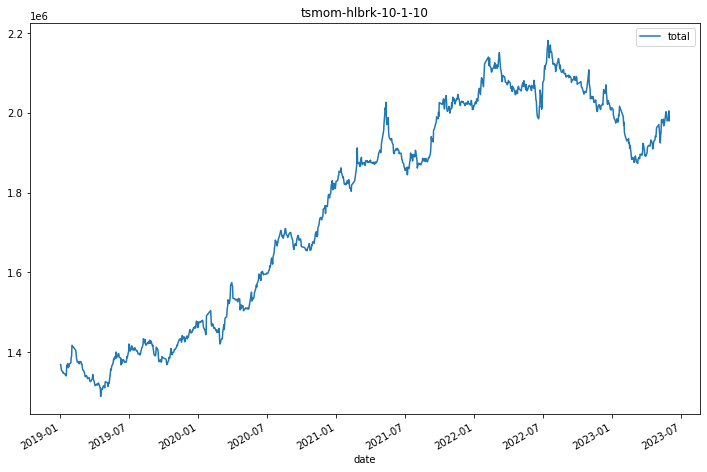

       sharpe       std  sortino
tenor                           
all      1.28   8047.02     1.86
6m      -0.37  11143.36    -0.49
1y      -0.44  12088.77    -0.58
2y       0.18  10915.05     0.25
3y       0.88  10498.87     1.23
4y       0.95   9976.02     1.34
5y       0.97   9471.73     1.39
6y       0.95   9190.25     1.37
7y       0.98   9010.60     1.44
8y       1.03   8966.94     1.49
9y       1.03   8694.38     1.50
10y      1.19   8477.01     1.73
11y      1.26   8310.61     1.83
run name: tsmom-hlbrk-30-1-10:

asset = rb, turnover per day = 0.10723195438613713, pnl per trade = 0.07133233509351783
asset = hc, turnover per day = 0.1038401465387257, pnl per trade = 0.17952999162720767
asset = i, turnover per day = 0.09799175615838127, pnl per trade = 0.016189344936627603
asset = j, turnover per day = 0.119186055939111, pnl per trade = 0.029258073970109016
asset = jm, turnover per day = 0.12005614407219062, pnl per trade = 0.030715407921850395
asset = ru, turnover per day = 0.12

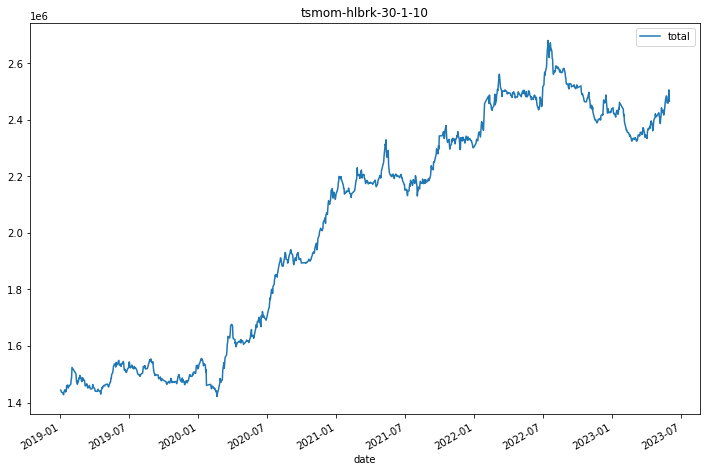

       sharpe       std  sortino
tenor                           
all      1.27  10064.67     1.86
6m       0.58  13465.56     0.79
1y      -0.08  13710.87    -0.11
2y       0.61  13457.72     0.95
3y       1.34  13141.03     2.02
4y       1.21  12375.42     1.76
5y       1.20  11632.53     1.75
6y       1.08  11293.31     1.60
7y       1.04  11227.01     1.57
8y       1.13  11142.40     1.68
9y       1.13  10820.06     1.68
10y      1.24  10555.08     1.85
11y      1.31  10403.87     1.95
run name: tsmom-hlbrk-240-1-10:

asset = rb, turnover per day = 0.050711837091080486, pnl per trade = 0.1117987289354749
asset = hc, turnover per day = 0.05129467622642427, pnl per trade = 0.1866268249330266
asset = i, turnover per day = 0.04782828203229778, pnl per trade = 0.02111536278901265
asset = j, turnover per day = 0.053762853316795506, pnl per trade = 0.08654561584698926
asset = jm, turnover per day = 0.05400207989978644, pnl per trade = 0.02805843963269728
asset = ru, turnover per day = 0.0

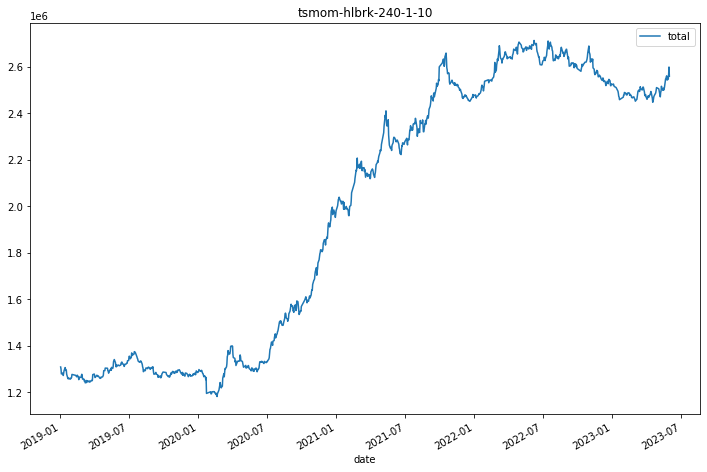

       sharpe       std  sortino
tenor                           
all      1.30  10171.17     1.81
6m       0.01  10540.71     0.02
1y      -0.70  11743.40    -1.01
2y       0.71  12993.01     1.07
3y       1.92  14030.16     2.93
4y       1.53  13071.31     2.23
5y       1.46  12131.64     2.10
6y       1.24  11450.22     1.78
7y       1.34  11421.80     1.96
8y       1.26  11513.49     1.83
9y       1.25  11336.63     1.83
10y      1.40  11047.36     2.04
11y      1.39  10730.04     2.01
run name: tsmom-macdnma-8-160-5:

asset = rb, turnover per day = 0.13554334301952312, pnl per trade = 0.030533232031347567
asset = hc, turnover per day = 0.12485986442643868, pnl per trade = 0.060099112449718745
asset = i, turnover per day = 0.13118981966846452, pnl per trade = 0.00515136089141549
asset = j, turnover per day = 0.14462141443401821, pnl per trade = 0.01172607539201901
asset = jm, turnover per day = 0.1640444635953038, pnl per trade = 0.002643258817695354
asset = ru, turnover per day = 

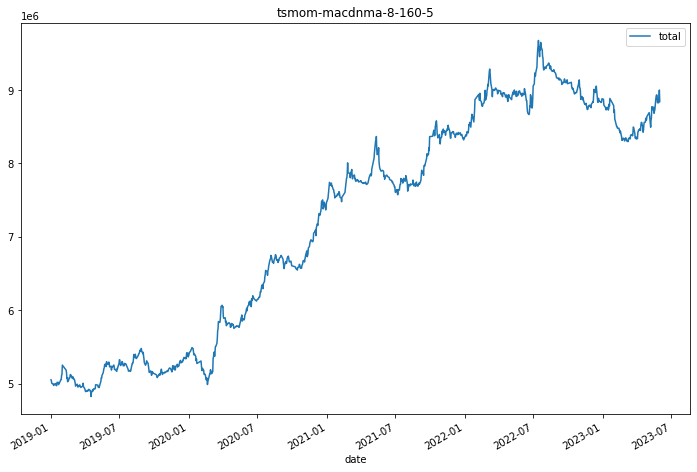

       sharpe       std  sortino
tenor                           
all      1.24  36975.54     1.79
6m       0.14  54425.26     0.19
1y      -0.11  55365.48    -0.15
2y       0.59  51877.45     0.88
3y       1.25  50008.86     1.83
4y       1.22  47019.30     1.81
5y       1.14  44204.86     1.69
6y       1.04  42815.27     1.54
7y       1.04  42094.23     1.56
8y       1.12  42012.34     1.68
9y       1.09  40636.33     1.62
10y      1.14  39325.54     1.70
11y      1.21  38494.82     1.79
run name: tsmom-macdnma-16-160-5:

asset = rb, turnover per day = 0.0836804264685019, pnl per trade = 0.02456624298266142
asset = hc, turnover per day = 0.08268349040306136, pnl per trade = 0.04932525692155125
asset = i, turnover per day = 0.08172590050454018, pnl per trade = 0.005579911194469956
asset = j, turnover per day = 0.0999481129487962, pnl per trade = 0.012586082082921177
asset = jm, turnover per day = 0.0933766513654764, pnl per trade = 0.006630230713428115
asset = ru, turnover per day = 0

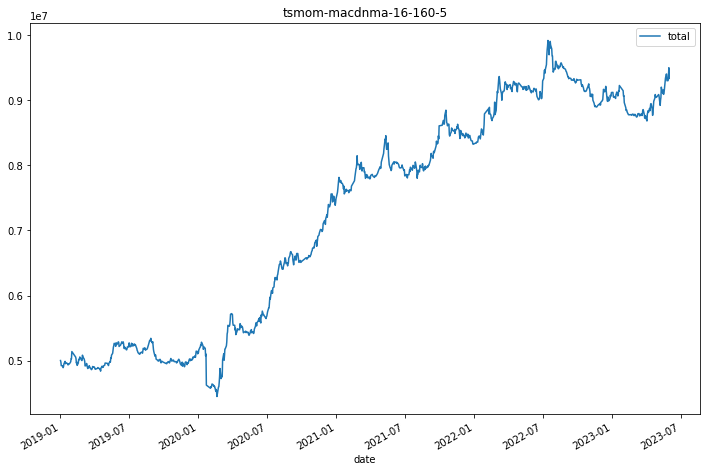

       sharpe       std  sortino
tenor                           
all      1.19  40757.57     1.61
6m       0.88  55909.02     1.22
1y       0.22  54492.05     0.30
2y       0.77  54227.81     1.16
3y       1.55  53169.73     2.29
4y       1.24  52843.66     1.64
5y       1.16  49307.46     1.55
6y       0.98  47475.58     1.33
7y       0.98  46652.53     1.36
8y       1.09  46413.70     1.53
9y       1.08  44855.02     1.51
10y      1.14  43302.39     1.58
11y      1.17  42465.13     1.62
run name: xsmom-rank_cutoff-hlbrk-20-1-10:

asset = rb, turnover per day = 0.1870704472001974, pnl per trade = 0.04518794284765111
asset = hc, turnover per day = 0.1654858202056238, pnl per trade = 0.23606617741539251
asset = i, turnover per day = 0.1606219004558204, pnl per trade = 0.012575827833848916
asset = j, turnover per day = 0.18649798189660619, pnl per trade = -0.021191501691650558
asset = jm, turnover per day = 0.1803201890703221, pnl per trade = -0.003733833947732434
asset = ru, turnover p

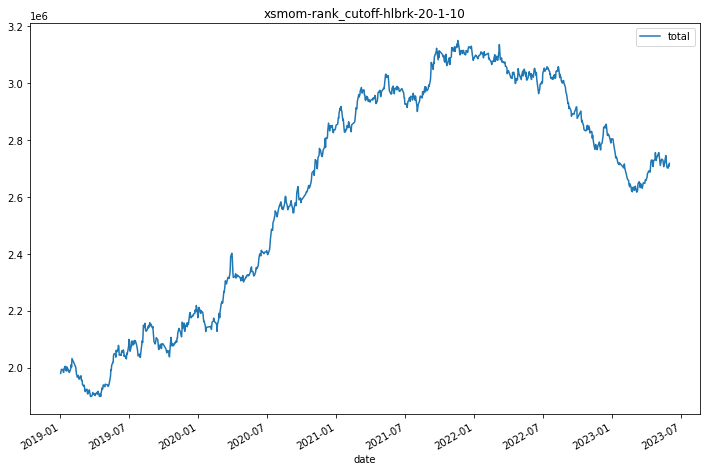

       sharpe       std  sortino
tenor                           
all      1.39  10171.75     2.21
6m      -0.66  11371.92    -0.95
1y      -1.74  11566.66    -2.40
2y      -0.73  12001.30    -1.07
3y       0.69  12143.97     1.06
4y       0.86  12325.15     1.38
5y       0.84  11926.63     1.35
6y       0.84  11775.46     1.38
7y       0.71  11477.30     1.15
8y       0.89  11176.29     1.45
9y       1.01  10986.39     1.63
10y      1.26  10820.19     2.04
11y      1.42  10605.71     2.29
run name: xsmom-rank_cutoff-hlbrk-120-1-10:

asset = rb, turnover per day = 0.11533300823292825, pnl per trade = 0.10020423811623909
asset = hc, turnover per day = 0.10828212110922998, pnl per trade = 0.22027589096888883
asset = i, turnover per day = 0.06796006873542954, pnl per trade = 0.018514235696162618
asset = j, turnover per day = 0.12835991852594894, pnl per trade = 0.023287349490330133
asset = jm, turnover per day = 0.11914780548106145, pnl per trade = -0.0015699044275934815
asset = ru, turno

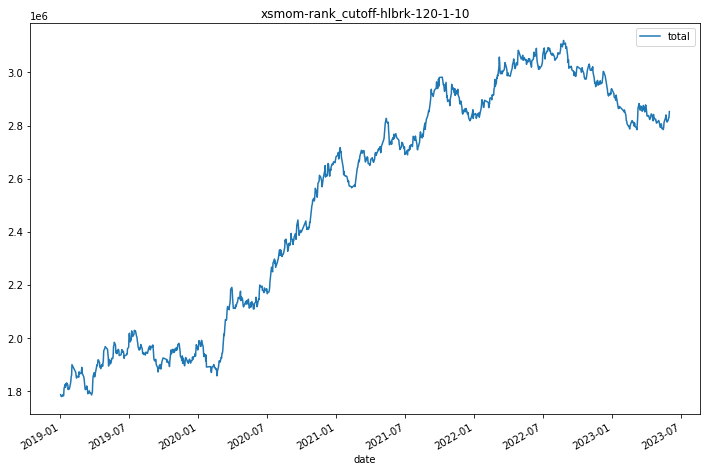

       sharpe       std  sortino
tenor                           
all      1.31  11711.16     2.09
6m      -1.27  11803.92    -2.14
1y      -0.99  11963.90    -1.54
2y       0.24  13283.70     0.38
3y       1.11  13872.44     1.81
4y       1.06  13824.73     1.76
5y       1.13  13799.94     1.90
6y       0.91  13466.92     1.48
7y       0.88  13132.97     1.45
8y       0.89  12734.84     1.45
9y       0.97  12501.91     1.59
10y      1.19  12319.49     1.93
11y      1.36  12045.15     2.19
run name: xsmom-rank_cutoff-hlbrk-240-1-10:

asset = rb, turnover per day = 0.10085250701236997, pnl per trade = 0.07645328792239404
asset = hc, turnover per day = 0.11213819505257597, pnl per trade = 0.07723905072150619
asset = i, turnover per day = 0.06155178714499511, pnl per trade = 0.01157104294487246
asset = j, turnover per day = 0.14060673455452075, pnl per trade = 0.2399378280611196
asset = jm, turnover per day = 0.10595569463469819, pnl per trade = 0.001545764670627434
asset = ru, turnover p

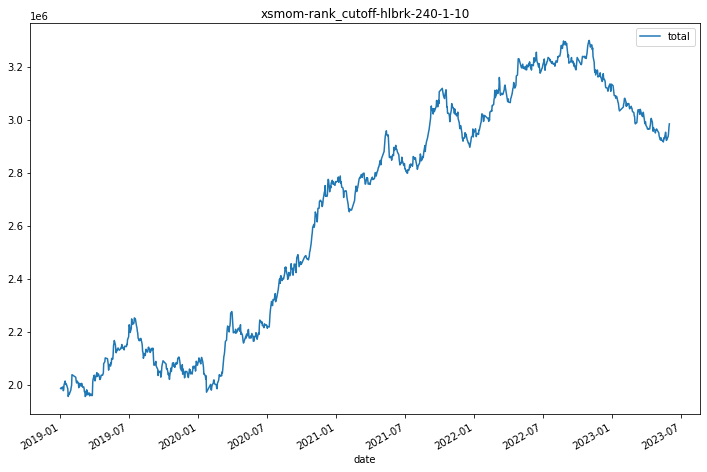

       sharpe       std  sortino
tenor                           
all      1.42  11846.33     2.22
6m      -2.27  10971.53    -3.76
1y      -1.20  11767.18    -1.75
2y       0.28  13388.91     0.44
3y       1.23  13972.27     1.98
4y       0.98  14045.65     1.57
5y       1.17  13874.89     1.91
6y       1.06  13463.89     1.69
7y       1.08  13171.13     1.74
8y       1.02  12869.71     1.63
9y       1.05  12583.69     1.68
10y      1.30  12376.97     2.06
11y      1.43  12001.05     2.23
run name: xsmom-rank_cutoff-momnma-130-90-5:

asset = rb, turnover per day = 0.10628299258421532, pnl per trade = 0.020235340427145466
asset = hc, turnover per day = 0.11525919471070845, pnl per trade = 0.15940348205783314
asset = i, turnover per day = 0.057843340607478, pnl per trade = 0.012884607966197774
asset = j, turnover per day = 0.1711045709437367, pnl per trade = 0.10479754542131549
asset = jm, turnover per day = 0.10781042394062262, pnl per trade = 0.012103286027842058
asset = ru, turnover 

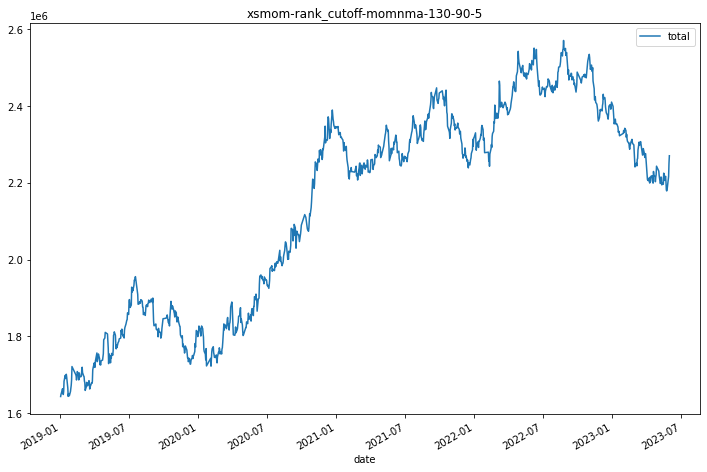

       sharpe       std  sortino
tenor                           
all      1.06  12009.76     1.65
6m      -1.22  12691.00    -2.24
1y      -1.13  13224.96    -1.85
2y      -0.05  14272.78    -0.08
3y       0.54  14608.87     0.88
4y       0.56  14401.80     0.91
5y       0.70  14189.89     1.14
6y       0.66  13714.70     1.07
7y       0.78  13472.88     1.26
8y       0.80  13212.86     1.29
9y       0.80  12865.16     1.27
10y      1.02  12618.34     1.62
11y      1.09  12218.13     1.71
run name: xsmom-momnma-240-90-5:

asset = rb, turnover per day = 0.12509716034201135, pnl per trade = 0.09326634120594429
asset = hc, turnover per day = 0.12198286517011427, pnl per trade = 0.21601224090533827
asset = i, turnover per day = 0.04980093079860616, pnl per trade = 0.007499401817766643
asset = j, turnover per day = 0.07471892626892362, pnl per trade = 0.13905285371404982
asset = jm, turnover per day = 0.08785900552569377, pnl per trade = 0.02159892534124609
asset = ru, turnover per day = 0

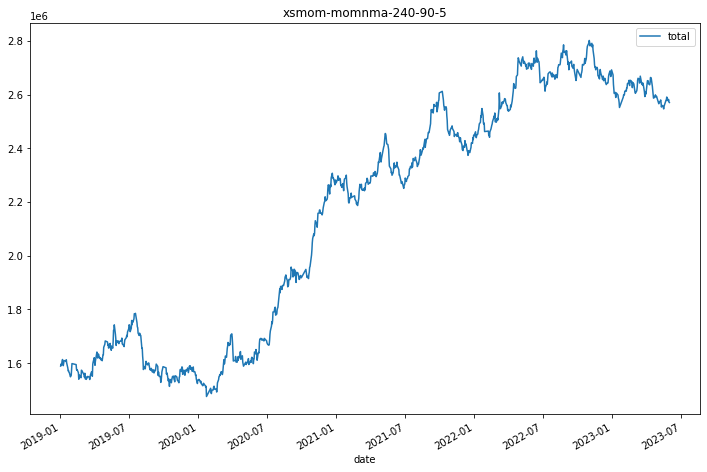

       sharpe       std  sortino
tenor                           
all      1.26  11905.20     1.94
6m      -1.25  12701.60    -2.03
1y      -0.64  13743.09    -0.99
2y       0.59  14136.78     0.96
3y       1.39  14343.15     2.33
4y       1.02  14112.51     1.64
5y       1.06  13941.38     1.73
6y       1.07  13589.93     1.73
7y       1.16  13266.16     1.87
8y       1.05  12997.40     1.68
9y       0.96  12649.47     1.52
10y      1.15  12294.58     1.80
11y      1.26  11928.28     1.95
run name: custom-hc_rb_diff-20-122-1:

asset = rb, turnover per day = 0.45778909790461336, pnl per trade = 0.29122072614928823
asset = hc, turnover per day = 0.45882269626935596, pnl per trade = 0.2723754371265524
asset = i, turnover per day = 0.4678824970630686, pnl per trade = 0.02548843935911618
asset = j, turnover per day = 0.4613943850621711, pnl per trade = 0.15243212153253438
asset = jm, turnover per day = 0.4595587472933879, pnl per trade = 0.04401931364153635
asset = FG, turnover per day = 0

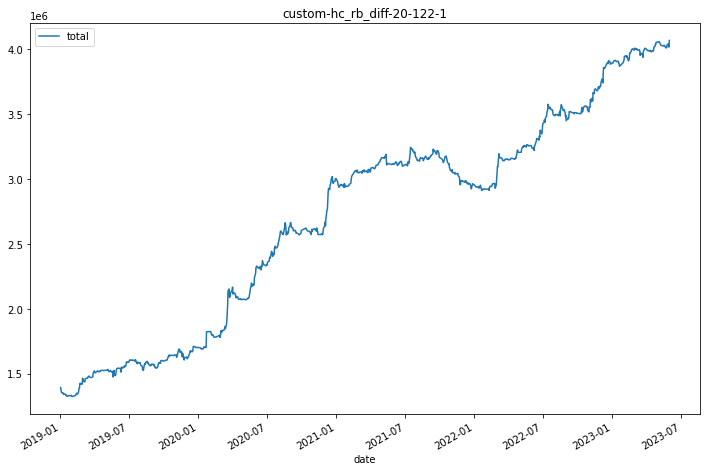

       sharpe       std  sortino
tenor                           
all      1.61  18170.75     2.82
6m       2.94  15322.39     6.48
1y       2.98  17322.07     5.72
2y       1.88  16177.71     3.58
3y       2.36  16576.75     4.25
4y       2.40  16888.67     4.28
5y       2.14  16603.48     3.57
6y       1.76  16557.82     2.85
7y       1.73  16773.21     2.78
8y       1.70  19175.82     3.14
9y       1.61  18170.75     2.82
10y      1.61  18170.75     2.82
11y      1.61  18170.75     2.82


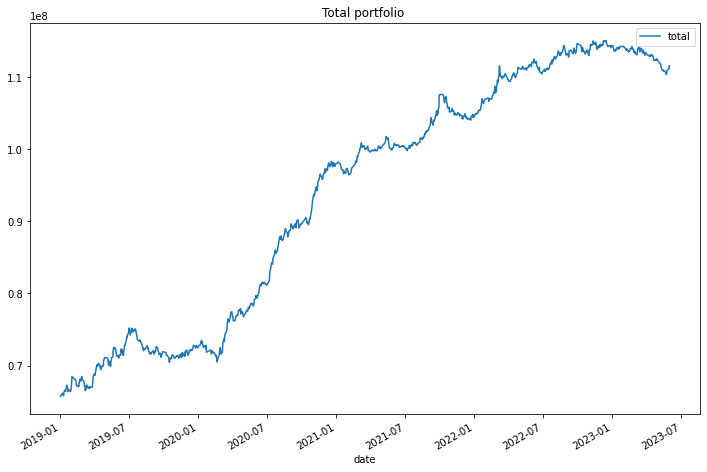

total portfolio stats:

asset = rb, turnover per day = 0.12298872438001535, pnl per trade = 0.005239618137004068
asset = hc, turnover per day = 0.10281834356016255, pnl per trade = 0.006766025799656297
asset = i, turnover per day = 0.07839826640110752, pnl per trade = 0.000447194131843427
asset = j, turnover per day = 0.13443746895718642, pnl per trade = 0.005471158819812449
asset = jm, turnover per day = 0.10347837883339908, pnl per trade = 0.0005454526108862966
asset = ru, turnover per day = 0.10121158789622105, pnl per trade = 0.04089782213066632
asset = FG, turnover per day = 0.10430053852420983, pnl per trade = 0.0005497173054054369
asset = cu, turnover per day = 0.1988372451051864, pnl per trade = 0.3745974022664109
asset = al, turnover per day = 0.15812895607076632, pnl per trade = 0.04762508193432041
asset = zn, turnover per day = 0.20839414771426673, pnl per trade = 0.07057817436761694
asset = sn, turnover per day = 0.23948802075724906, pnl per trade = 43.940867175826625
asset

In [10]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = tday

scenario_map = {
    'test': scenarios_test,
    'elite': scenarios_elite,
}

shift_mode = 1
rev_char = '!'
exec_mode = 'open'
cost_ratio = 0.5
total_risk = 4600.0*34
asset_scaling = False

std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'sn',
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd',
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni']

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

scenario_name = 'elite'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame()
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2019-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['total_risk'] = total_risk
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['cost_ratio'] = cost_ratio
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    
    print(f'run name: {run_name}:\n')
    for asset in bt_metrics.holdings.columns:
        holding = bt_metrics.holdings[asset][port_start:]
        pnl = pnl_stats['asset_pnl'][asset][port_start:]
        turnover = holding.diff().abs().mean()/holding.abs().mean()
        pnl_per_trade = pnl.mean()/holding.abs().mean()/holding.abs().mean()        
        #print(f'asset = {asset}, turnover per day = {turnover}, pnl per trade = {pnl_per_trade}')
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='px', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=pos_sum.index)

holdings[run_key] = pos_sum

bt_met = MetricsBase(holdings=pos_sum, returns=df_pxchg)
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()

print("total portfolio stats:\n")

for asset in bt_met.holdings.columns:
    holding = bt_met.holdings[asset][port_start:]
    pnl = port_stats['asset_pnl'][asset][port_start:]
    turnover = holding.diff().abs().mean()/holding.abs().mean()
    pnl_per_trade = pnl.mean()/holding.abs().mean()/holding.abs().mean()        
    print(f'asset = {asset}, turnover per day = {turnover}, pnl per trade = {pnl_per_trade}')
        
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))

bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
if shift_mode == 2:
    asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='ret')
else:
    asset_pnl = bt_met.calculate_daily_pnl(open_prices, close_prices, mode='px')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl_cal30b.csv")


# asset level cum pnl

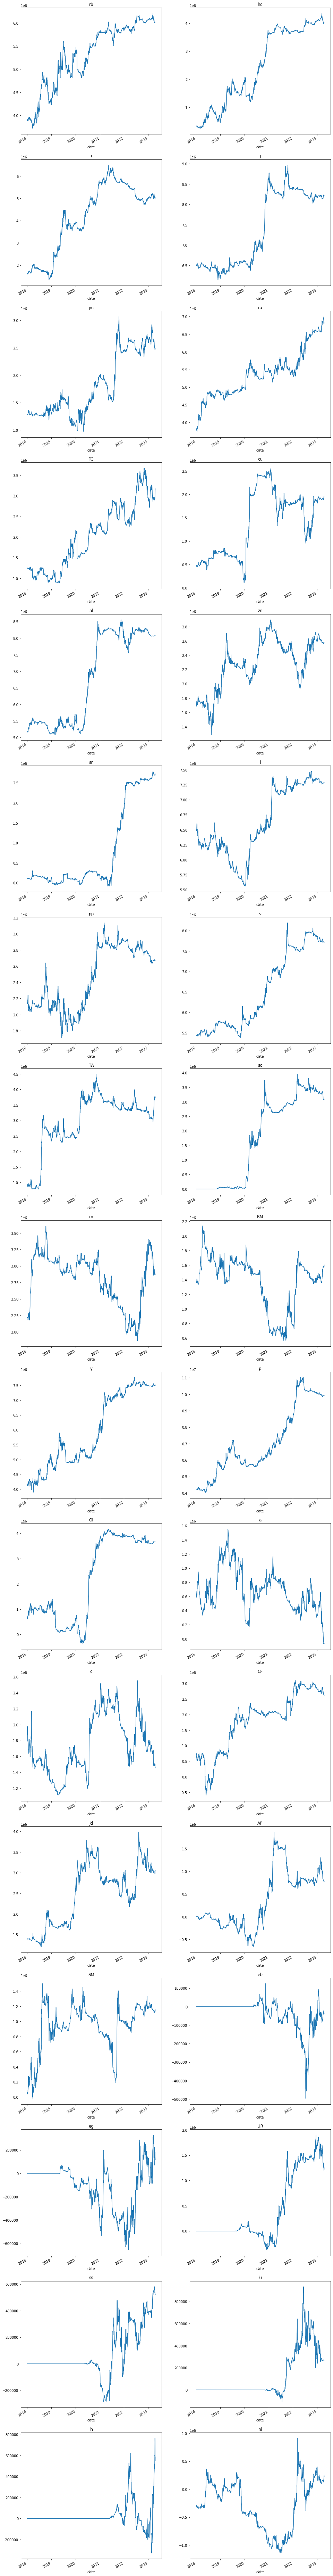

In [19]:
#plot_stats = scen_stats[0]
plot_stats = port_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2018-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

# print(asset_stats[product_list])
    